In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import glob
import os
import re

from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.dummy import DummyClassifier
from xgboost import XGBClassifier

import nltk
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords
from string import punctuation
import unidecode
nltk.download('averaged_perceptron_tagger')

os.chdir('C:\\Users\\barry\\OneDrive - CSTBGroup\\image_ds\\images')


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\barry\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [2]:
X = pd.read_csv('X_train_update.csv',index_col=0)
y = pd.read_csv('Y_train_CVw08PX.csv',index_col=0)
X = X.drop(["productid", "imageid", "description"], axis = 1)
df= X.merge(y,  right_index = True, left_index = True)


https://www.kaggle.com/diveki/classification-with-nlp-xgboost-and-pipelines

### Filtrage

##### Suppression des duplicats car peut donner trop de poids à des mots
##### Suppression des lignes avec valeurs manquantes car on ne peut les combler

In [3]:
data_single = df.drop_duplicates('designation')
data_single = data_single.dropna(subset=['designation'])
data_single.head()

,designation,prdtypecode
0,Olivia: Personalisiertes Notizbuch / 150 Seite...,10
1,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...,2280
2,Grand Stylet Ergonomique Bleu Gamepad Nintendo...,50
3,Peluche Donald - Europe - Disneyland 2000 (Mar...,1280
4,La Guerre Des Tuques,2705


##### Représentation du label

In [4]:
data_single.iloc[:,-1].value_counts()
# Il y a un certain déséquilibrage dans la représentation des labels, voir si on fera un RandomOverSample
# ou UnderSample ou techniques similaires

2583    9717
1300    4988
2522    4930
1560    4922
1280    4777
2403    4763
2280    4753
2060    4540
1160    3952
1920    3836
1320    3196
10      3114
2705    2753
1140    2670
2582    2497
40      2478
2585    2428
1302    2302
1281    1986
50      1633
2462    1406
2905     872
2220     817
1940     802
60       774
1180     764
1301     595
Name: prdtypecode, dtype: int64

### Travail sur le texte

Tout en miniscule : 

In [5]:
for col in data_single.iloc[:,:-1]:
    data_single[col] = data_single[col].str.lower()

Suppression des accents : 

In [6]:
def unidecode_text(text):
    try:
        text = unidecode.unidecode(text)
    except:
        pass
    return text

for col in data_single.iloc[:,:-1]:
    data_single[col] = data_single.apply(lambda row: unidecode_text(row[col]), axis=1)

Mots vides : 

In [7]:
eng_words = stopwords.words("english")
germ_words =stopwords.words("german")
french_words =stopwords.words("french")

stop_words1 = eng_words + germ_words + french_words

Racinisation :

In [8]:
defTags = ['NN', 'NNS', 'NNP', 'NNPS', 'JJ', 'JJS', 'JJR']#, 'RB', 'RBS', 'RBR', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']


# functions to determine the type of a word
def is_noun(tag):
    return tag in ['NN', 'NNS', 'NNP', 'NNPS']


def is_verb(tag):
    return tag in ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']


def is_adverb(tag):
    return tag in ['RB', 'RBR', 'RBS']


def is_adjective(tag):
    return tag in ['JJ', 'JJR', 'JJS']

# transform tag forms
def penn_to_wn(tag):
    if is_adjective(tag):
        return nltk.stem.wordnet.wordnet.ADJ
    elif is_noun(tag):
        return nltk.stem.wordnet.wordnet.NOUN
    elif is_adverb(tag):
        return nltk.stem.wordnet.wordnet.ADV
    elif is_verb(tag):
        return nltk.stem.wordnet.wordnet.VERB
    return nltk.stem.wordnet.wordnet.NOUN


# lemmatizer + tokenizer (+ stemming) class
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
        # we define (but not use) a stemming method, uncomment the last line in __call__ to get stemming tooo
        self.stemmer = nltk.stem.SnowballStemmer('english') 
    def __call__(self, doc):
        # pattern for numbers | words of length=2 | punctuations | words of length=1
        pattern = re.compile(r'[0-9]+|\b[\w]{2,2}\b|[%.,_`!"&?\')({~@;:#}+-]+|\b[\w]{1,1}\b')
        # tokenize document
        doc_tok = word_tokenize(doc)
        #filter out patterns from words
        doc_tok = [x for x in doc_tok if x not in stop_words1]
        doc_tok = [pattern.sub('', x) for x in doc_tok]
        # get rid of anything with length=1
        doc_tok = [x for x in doc_tok if len(x) > 1]
        # position tagging
        doc_tagged = nltk.pos_tag(doc_tok)
        # selecting nouns and adjectives
        doc_tagged = [(t[0], t[1]) for t in doc_tagged if t[1] in defTags]
        # preparing lemmatization
        doc = [(t[0], penn_to_wn(t[1])) for t in doc_tagged]
        # lemmatization
        doc = [self.wnl.lemmatize(t[0], t[1]) for t in doc]
        # uncomment if you want stemming as well
        #doc = [self.stemmer.stem(x) for x in doc]
        return doc

Tf-idf Vectorizer (mise en forme pour modélisation)

In [9]:
vec_tdidf = TfidfVectorizer(ngram_range=(1,1), analyzer='word', stop_words=stop_words1, 
                                               norm='l2', tokenizer=LemmaTokenizer())

### Modélisation XGBoost

Train test split

df = data_single.copy()

X_train, X_test, y_train, y_test = train_test_split(df['designation'], df['prdtypecode'], 
                                                    test_size=0.2, random_state=42)
X_train, X_val, y_val, y_val = train_test_split(X_train, y_train, 
                                                    test_size=0.4, random_state=42)

Initialisation 

In [10]:
clf = XGBClassifier(random_state=42, seed=2, colsample_bytree=0.6, subsample=0.7, learning_rate = 0.1)

Pipeline composante

In [11]:
class TextSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations
    on
    Use on text columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None, *parg, **kwarg):
        return self

    def transform(self, X):
        # returns the input as a string
        return X[self.key]

Fonction pour l'évaluation

In [12]:
def print_stats(preds, target, labels, sep='-', sep_len=40, fig_size=(10,8)):
    print('Accuracy = %.3f' % metrics.accuracy_score(target, preds))
    print(sep*sep_len)
    print('Classification report:')
    print(metrics.classification_report(target, preds))
    print(sep*sep_len)
    print('Confusion matrix')
    cm=metrics.confusion_matrix(target, preds)
    cm = cm / np.sum(cm, axis=1)[:,None]
    sns.set(rc={'figure.figsize':fig_size})
    sns.heatmap(cm, 
        xticklabels=labels,
        yticklabels=labels,
           annot=True, cmap = 'YlGnBu')
    plt.pause(0.05)

Construction Pipeline

In [13]:
text = Pipeline([
                ('selector', TextSelector(key='designation')),
                ('vectorizer', vec_tdidf)
                ])

feats = FeatureUnion([
                      ('designation', text)
                      ])

pipe = Pipeline([('feats', feats),
                 ('clf',clf)
                 ])

### Hyperparamétrisation

Liste paramètres

In [14]:
pipe.named_steps['clf'].get_params()

{'objective': 'binary:logistic',
 'use_label_encoder': True,
 'base_score': None,
 'booster': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': 0.6,
 'gamma': None,
 'gpu_id': None,
 'importance_type': 'gain',
 'interaction_constraints': None,
 'learning_rate': 0.1,
 'max_delta_step': None,
 'max_depth': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 100,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': 42,
 'reg_alpha': None,
 'reg_lambda': None,
 'scale_pos_weight': None,
 'subsample': 0.7,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None,
 'seed': 2}

Liste hyperparamètres à tester dans la GridSearch

In [15]:
learning_rate = [ 0.01, 0.1, 0.3]

param_grid = {'clf__learning_rate': learning_rate,
     'clf__n_estimators': [50,100,300], 
#    'clf__colsample_bytree': [0.6,0.8,1],
#    'clf__subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1]
}

Grid Search Paramétrisation

In [16]:
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=7)
grid_search = GridSearchCV(estimator = pipe, param_grid = param_grid, 
                          cv = kfold, n_jobs = -1, return_train_score=True, verbose = 2)

Train_test_split

In [17]:
kaggle_input = data_single.copy()
combined_features = [ 'designation']
target = 'prdtypecode'

X_train, X_test, y_train, y_test = train_test_split(kaggle_input[[ 'designation']], kaggle_input[target], 
                                                    test_size=0.33, random_state=42, stratify=kaggle_input[target])


Recherche hyperparamètres

In [19]:
grid_search.fit(X_train, y_train)
grid_search.best_params_

Fitting 3 folds for each of 9 candidates, totalling 27 fits


C:\Users\barry\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['need', 'sha'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '
C:\Users\barry\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:01:16] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


{'clf__learning_rate': 0.3, 'clf__n_estimators': 300}

Résultats 

In [20]:
print(grid_search.cv_results_['mean_train_score'])
grid_search.cv_results_['mean_test_score']

[0.60399696 0.6191284  0.66042236 0.69152893 0.74436207 0.82558919
 0.77619428 0.82271348 0.89081408]


array([0.58208903, 0.59544244, 0.62269357, 0.64217937, 0.67409317,
       0.70898275, 0.69080325, 0.70461024, 0.71315572])

Prédiction



In [21]:
clf_test = grid_search.best_estimator_
preds = clf_test.predict(X_test)


Evaluation

Accuracy = 0.732
----------------------------------------
Classification report:
              precision    recall  f1-score   support

          10       0.54      0.28      0.37      2027
          40       0.56      0.60      0.58       759
          50       0.73      0.72      0.72       547
          60       0.80      0.81      0.80       252
        1140       0.70      0.70      0.70       883
        1160       0.77      0.84      0.81      1197
        1180       0.50      0.65      0.56       192
        1280       0.60      0.64      0.62      1466
        1281       0.46      0.54      0.50       552
        1300       0.85      0.88      0.86      1587
        1301       0.71      0.83      0.76       168
        1302       0.67      0.78      0.72       653
        1320       0.67      0.73      0.70       970
        1560       0.78      0.77      0.78      1654
        1920       0.88      0.87      0.88      1284
        1940       0.62      0.73      0.67       226


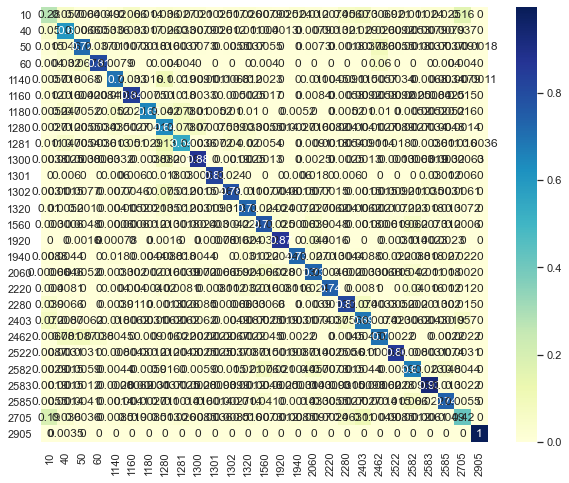

In [22]:
print_stats(y_test, preds, clf_test.classes_)